In [55]:
import os
import gc
import re
import json
import pickle
import datetime
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.options.display.max_columns = None

from typing import Union

import seaborn
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_formats = {'png', 'retina'}

from scipy.stats import linregress

from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import lightgbm as lgb

In [3]:
VERSION = 'v00000'

In [4]:
train = pd.read_pickle('features/add_sales_train.pkl')

In [5]:
print(train.shape)
train.head()

(46668247, 63)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,month,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,quarter,weekofyear,day,dayofweek,is_quarter_end,is_quarter_start,is_month_end,is_month_start,is_weekend,sell_price,sell_price_rate_by_wm_yr_wk__item_id,sell_price_rate_by_wm_yr_wk__area__item_id,sell_price_momentum,sales_lag_t28,sales_lag_t29,sales_lag_t30,sales_lag_t32,sales_lag_t33,sales_lag_t34,sales_rolling_STD_t7,sales_rolling_STD_t30,sales_rolling_STD_t60,sales_rolling_STD_t90,sales_rolling_STD_t180,sales_rolling_MEAN_t7,sales_rolling_MEAN_t30,sales_rolling_MEAN_t60,sales_rolling_MEAN_t90,sales_rolling_MEAN_t180,sales_rolling_MIN_t7,sales_rolling_MIN_t30,sales_rolling_MIN_t60,sales_rolling_MAX_t7,sales_rolling_MAX_t30,sales_rolling_MAX_t60,sales_rolling_ZeroRatio_t7,sales_rolling_ZeroCount_t7,sales_rolling_ZeroRatio_t14,sales_rolling_ZeroCount_t14,sales_rolling_ZeroRatio_t30,sales_rolling_ZeroCount_t30,sales_rolling_ZeroRatio_t60,sales_rolling_ZeroCount_t60,sales_rolling_SKEW_t30,sales_rolling_KURT_t30
213437,HOBBIES_1_008_CA_1_validation,1444,3,1,0,0,d_8,5,2011-02-05,11102,2,19,2,3,1,1,1,1,1,5,5,5,0,0,0,0,1,0.459961,0.983887,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213438,HOBBIES_1_009_CA_1_validation,1445,3,1,0,0,d_8,9,2011-02-05,11102,2,19,2,3,1,1,1,1,1,5,5,5,0,0,0,0,1,1.559570,0.993652,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213439,HOBBIES_1_010_CA_1_validation,1446,3,1,0,0,d_8,0,2011-02-05,11102,2,19,2,3,1,1,1,1,1,5,5,5,0,0,0,0,1,3.169922,1.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213441,HOBBIES_1_012_CA_1_validation,1448,3,1,0,0,d_8,2,2011-02-05,11102,2,19,2,3,1,1,1,1,1,5,5,5,0,0,0,0,1,5.980469,0.985352,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
213444,HOBBIES_1_015_CA_1_validation,1451,3,1,0,0,d_8,0,2011-02-05,11102,2,19,2,3,1,1,1,1,1,5,5,5,0,0,0,0,1,0.700195,1.000000,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
def split_train_eval_submit(df, pred_interval=28):
    latest_date = df['date'].max()
    submit_date = latest_date - datetime.timedelta(days=pred_interval)
    submit_mask = (df["date"] > submit_date)

    eval_date = latest_date - datetime.timedelta(days=pred_interval * 2)
    eval_mask = ((df["date"] > eval_date) & (df["date"] <= submit_date))

    train_mask = ((~eval_mask) & (~submit_mask))
    return df[train_mask], df[eval_mask], df[submit_mask]

In [8]:
target = 'sales'
cols_to_drop = ['id', 'wm_yr_wk', 'd', 'date'] + [target]
features = train.columns.tolist()
features = [f for f in features if f not in cols_to_drop]

train_data, eval_data, submit_data = split_train_eval_submit(train)

In [10]:
def load_pickle(filepath):
    with open(filepath, 'rb') as file:
        return pickle.load(file)

In [11]:
models = load_pickle(f'result/model/v01004.pkl')
preds = [m.predict(eval_data[features].values, num_iteration=m.best_iteration) for m in models]
preds = np.mean(preds, axis=0)
metric_scores = {}
metric_scores['RMSE'] = mean_squared_error(eval_data['sales'].values, preds, squared=False)

In [12]:
metric_scores

{'RMSE': 2.1427751604900585}

In [ ]:
def ordered_d_cols(df_cols):
    return sorted(df_cols, key=lambda x: int((re.search(r"\d+", x)).group(0)))
# Processing train data.
df = pd.read_pickle('../data/reduced/sales_train_validation.pkl')
train_idx_labels = df.iloc[:, :-eval_days].copy(deep=True)
# Processing eval label data.
eval_labels = pd.pivot_table(
    eval_data, index='id', columns='d', values='sales', fill_value=0).reset_index()
eval_labels = eval_labels[ordered_d_cols(eval_labels.drop('id', axis=1).columns.tolist())]
# Processing eval predict data.
eval_data['pred'] = preds
pred_labels = pd.pivot_table(
    eval_data, index='id', columns='d', values='pred', fill_value=0).reset_index()
pred_labels = pred_labels[ordered_d_cols(pred_labels.drop('id', axis=1).columns.tolist())]

### 3 fold TimeSeriesSplitのモデルの重みを確かめる。

In [14]:
from sklearn.linear_model import LinearRegression

In [13]:
off_preds = [m.predict(eval_data[features].values, num_iteration=m.best_iteration) for m in models]

In [24]:
off_df = pd.DataFrame(np.array(off_preds).T)

In [27]:
lr = LinearRegression().fit(off_df.values, eval_data['sales'].values)
weights = {c: w for c, w in zip(off_df.columns, lr.coef_)}
weights

{0: 0.12483929977038609, 1: 0.2252741809134553, 2: 0.6733449189917613}

#### ついでにfoldごとのRMSEを出してみる。

In [28]:
models = load_pickle(f'result/model/v01004.pkl')

for i, m in enumerate(models):
    pred = m.predict(eval_data[features].values, num_iteration=m.best_iteration)
    rmse = mean_squared_error(eval_data['sales'].values, pred, squared=False)
    print(f'{i} fold model: {rmse:.04f}')

0 fold model: 2.3196
1 fold model: 2.1861
2 fold model: 2.1388


### そもそもちゃんと予測できているだろうか。

In [133]:
def ordered_d_cols(df_cols):
    return sorted(df_cols, key=lambda x: int((re.search(r"\d+", x)).group(0)))
# Processing train data.
df = pd.read_pickle('../data/reduced/sales_train_validation.pkl')
eval_days = 28
train_idx_labels = df.iloc[:, :-eval_days].copy(deep=True)
# Processing eval label data.
eval_labels = pd.pivot_table(
    eval_data, index='id', columns='d', values='sales', fill_value=0).reset_index()
eval_labels = eval_labels[['id'] + ordered_d_cols(eval_labels.drop('id', axis=1).columns.tolist())]
# Processing eval predict data.
eval_data['pred'] = preds
pred_labels = pd.pivot_table(
    eval_data, index='id', columns='d', values='pred', fill_value=0).reset_index()
pred_labels = pred_labels[['id'] + ordered_d_cols(pred_labels.drop('id', axis=1).columns.tolist())]

<ipython-input-133-99a94d45aaad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eval_data['pred'] = preds


In [145]:
eval_labels['category'] = eval_labels['id'].str.split('_', expand=True)[0]
eval_labels['area'] = eval_labels['id'].str.split('_', expand=True)[3]
eval_labels['item_id'] = eval_labels['id'].str.rsplit('_', n=4, expand=True)[0]

pred_labels['category'] = pred_labels['id'].str.split('_', expand=True)[0]
pred_labels['area'] = pred_labels['id'].str.split('_', expand=True)[3]
pred_labels['item_id'] = pred_labels['id'].str.rsplit('_', n=4, expand=True)[0]

In [146]:
print(eval_labels.shape)
display(eval_labels.head())

print(pred_labels.shape)
display(pred_labels.head())

(30490, 32)


d,id,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,category,area,item_id
0,FOODS_1_001_CA_1_validation,2,1,1,0,4,0,0,4,1,3,0,1,0,2,2,0,1,1,0,2,0,4,1,1,0,1,1,0,FOODS,CA,FOODS_1
1,FOODS_1_001_CA_2_validation,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,2,0,1,0,14,0,1,1,4,0,0,4,FOODS,CA,FOODS_1
2,FOODS_1_001_CA_3_validation,0,0,1,0,0,1,0,0,0,1,0,0,4,2,1,0,0,0,0,0,13,0,0,0,0,0,1,0,FOODS,CA,FOODS_1
3,FOODS_1_001_CA_4_validation,2,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1,FOODS,CA,FOODS_1
4,FOODS_1_001_TX_1_validation,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FOODS,TX,FOODS_1


(30490, 32)


d,id,d_1886,d_1887,d_1888,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,category,area,item_id
0,FOODS_1_001_CA_1_validation,0.604339,0.574446,0.587351,0.591404,0.648019,0.880780,0.824615,0.597501,0.585054,0.534151,0.566663,0.692437,0.774713,0.813102,0.594520,0.549708,0.559879,0.603869,0.687542,0.916806,0.926897,0.629441,0.665621,0.761487,0.695283,0.795720,1.003853,0.899540,FOODS,CA,FOODS_1
1,FOODS_1_001_CA_2_validation,0.909698,0.893796,0.973618,0.987595,1.112340,1.779229,1.450597,1.063223,1.019228,0.981074,0.989832,1.143126,1.322250,1.294095,1.107421,1.026746,0.964040,0.936481,1.026457,1.233255,1.243536,0.850914,0.839627,0.882701,0.840072,0.904161,1.198800,1.091556,FOODS,CA,FOODS_1
2,FOODS_1_001_CA_3_validation,1.244449,1.316257,1.207255,1.177226,1.360922,1.496047,1.357998,1.171317,1.099361,1.122568,1.079137,1.120099,1.306926,1.245036,1.192160,0.970076,0.981851,0.957631,0.977232,1.134390,1.287457,1.024659,0.928723,0.946587,1.005627,1.071645,1.749873,1.256609,FOODS,CA,FOODS_1
3,FOODS_1_001_CA_4_validation,0.162322,0.159654,0.160152,0.166036,0.296339,0.269543,0.268806,0.449647,0.357762,0.343564,0.435736,0.504051,0.488205,0.463554,0.366846,0.325562,0.339756,0.310991,0.361574,0.484338,0.432720,0.366197,0.355816,0.415862,0.377148,0.340917,0.481587,0.451108,FOODS,CA,FOODS_1
4,FOODS_1_001_TX_1_validation,0.516052,0.474573,0.488107,0.498636,0.563007,0.615615,0.792663,0.623179,0.593728,0.590893,0.609411,0.606776,0.678005,0.700996,0.655977,0.688652,0.671209,0.736638,0.800426,0.945064,0.847621,0.762762,0.733221,0.747012,0.664794,0.815665,0.903364,0.788300,FOODS,TX,FOODS_1


In [140]:
# plt.figure(figsize=(8,6))
# plt.plot(eval_labels.drop('id', axis=1).sum(axis=0).values, label='actual')
# plt.plot(pred_labels.drop('id', axis=1).sum(axis=0).values, label='predict')
# plt.legend()
# plt.show()

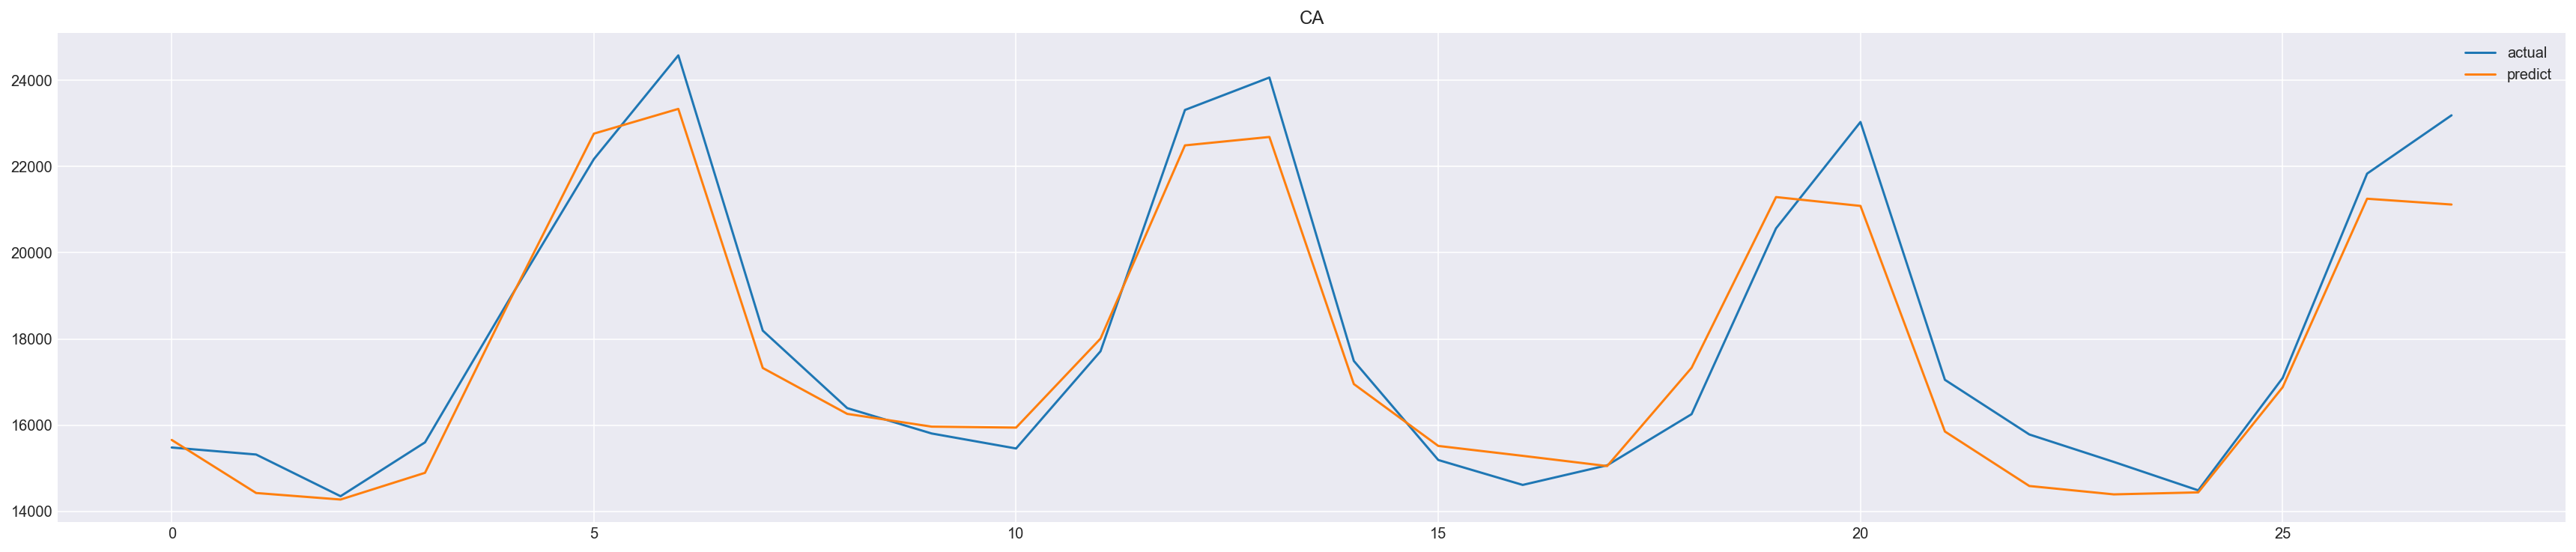

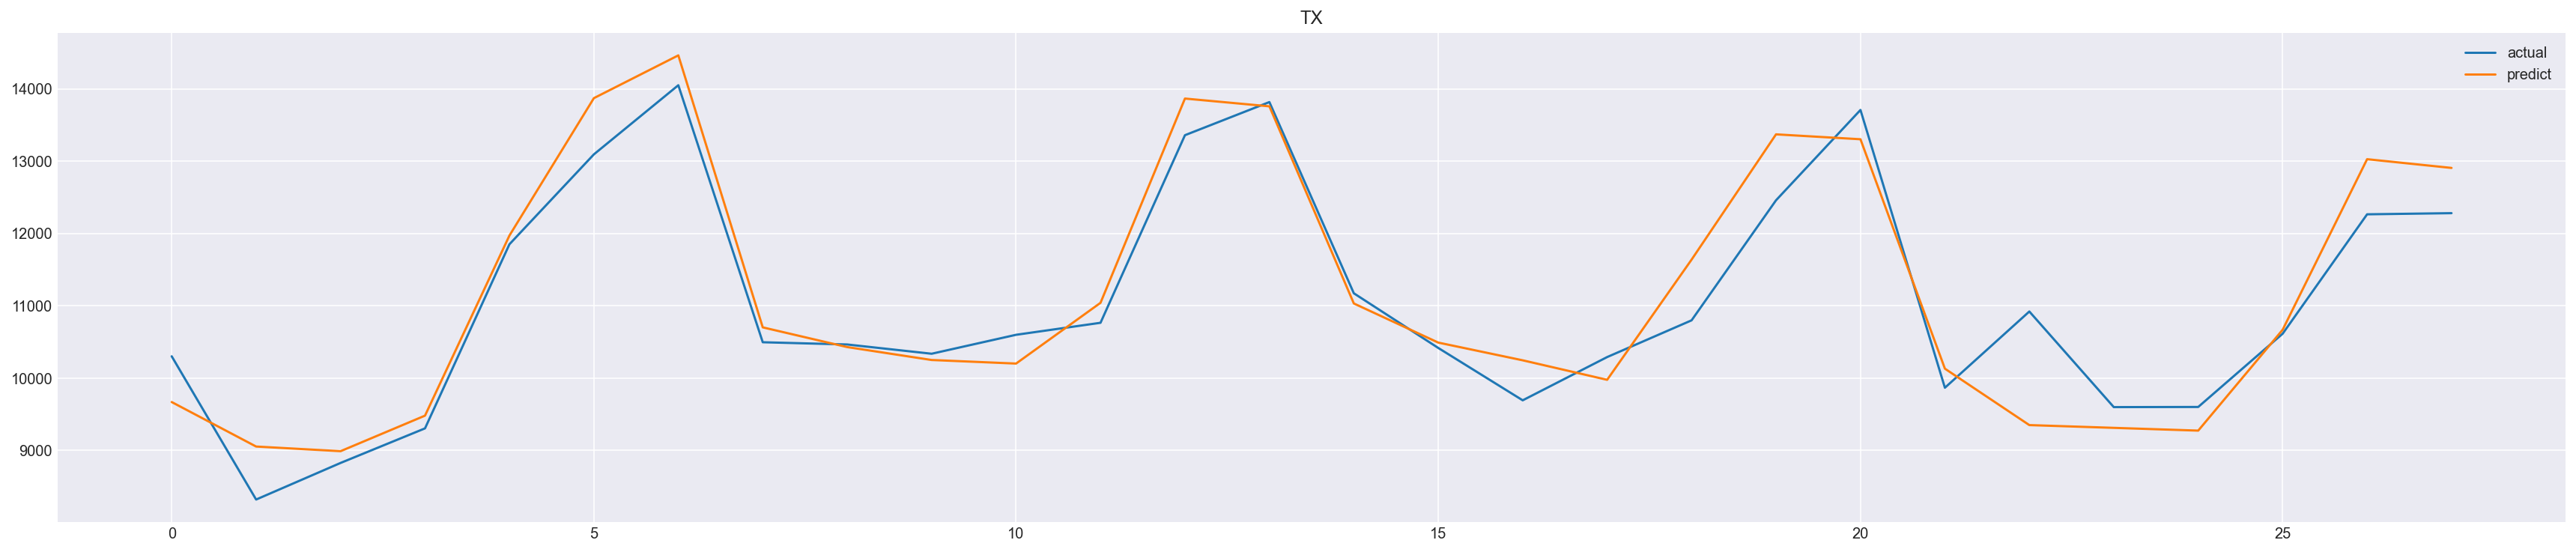

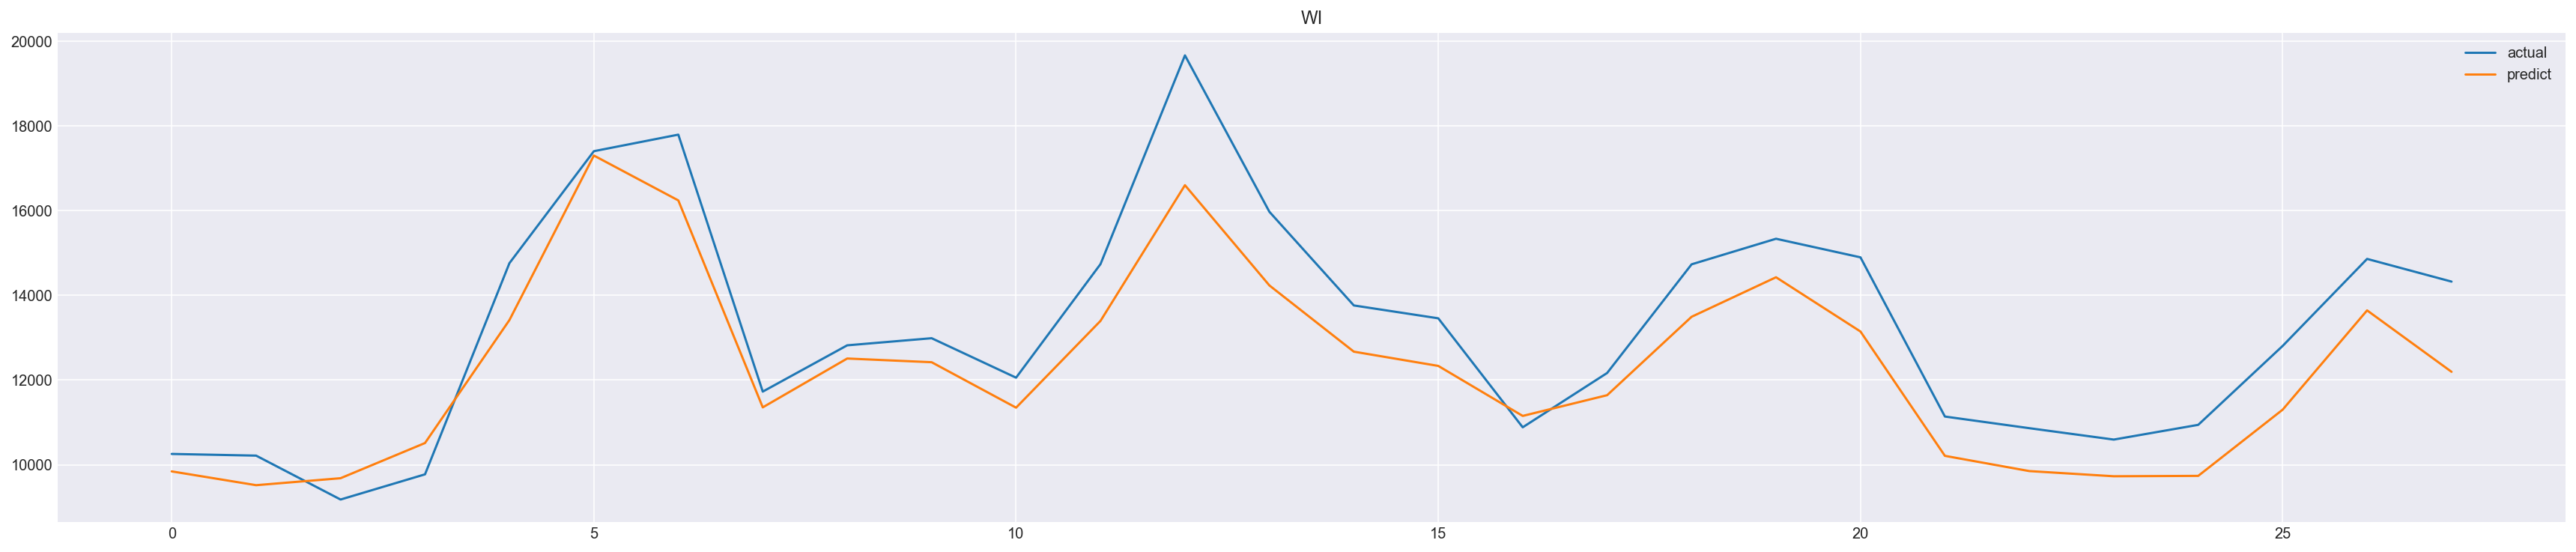

In [143]:
for a in eval_labels['area'].unique():
    actual = eval_labels.groupby('area').sum()
    actual = actual.loc[a].values
    predict = pred_labels.groupby('area').sum()
    predict = predict.loc[a].values
    
    plt.figure(figsize=(30, 6))
    plt.title(a)
    plt.plot(actual, label='actual')
    plt.plot(predict, label='predict')
    plt.legend()
    plt.show()

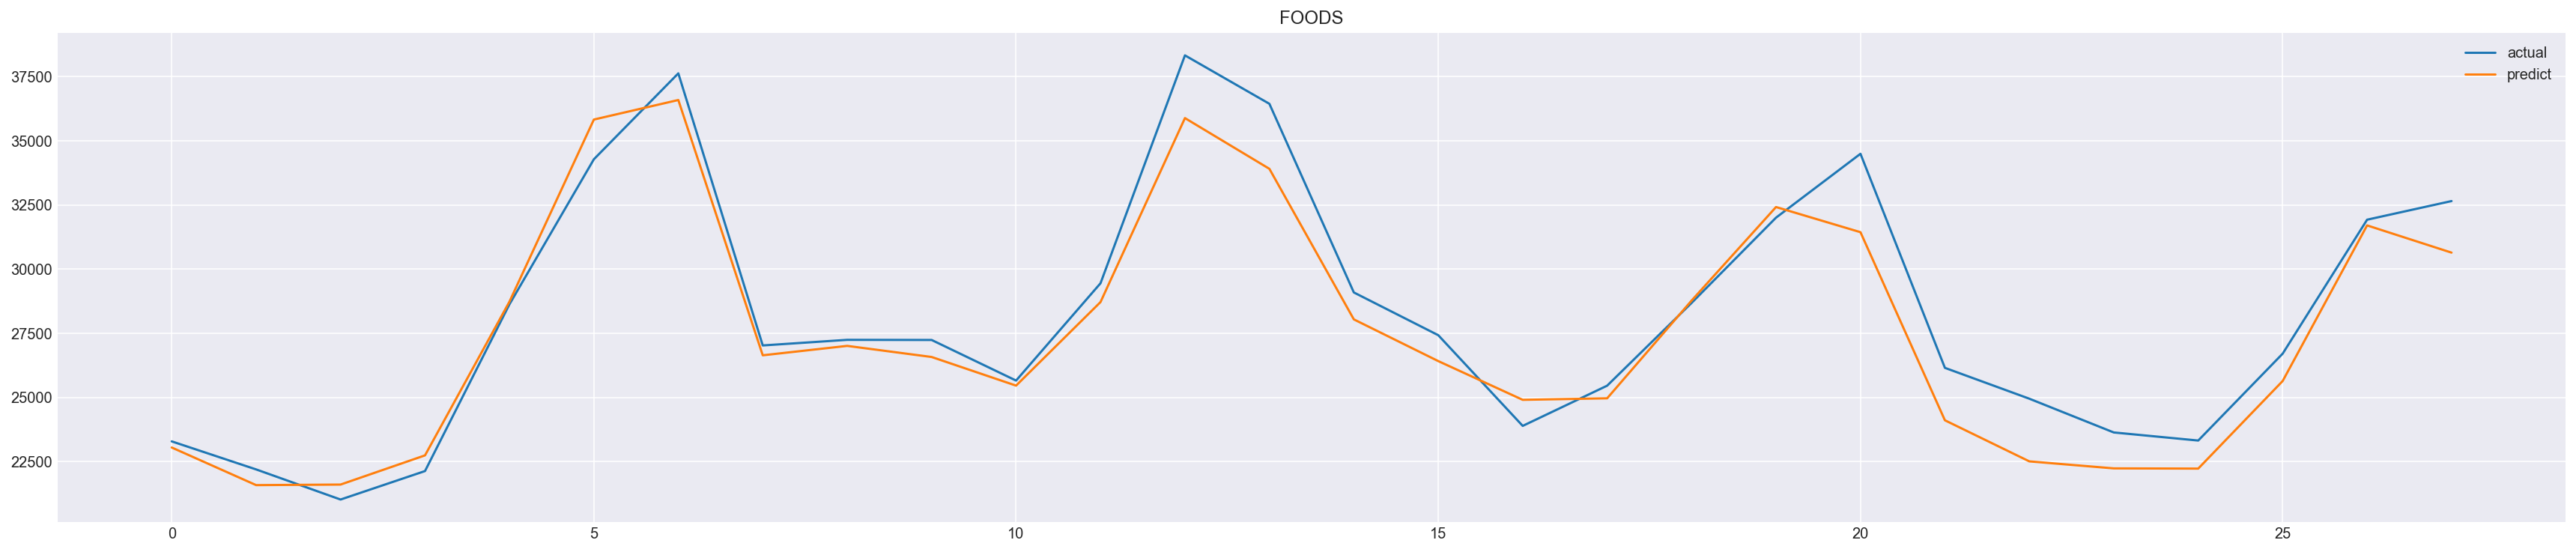

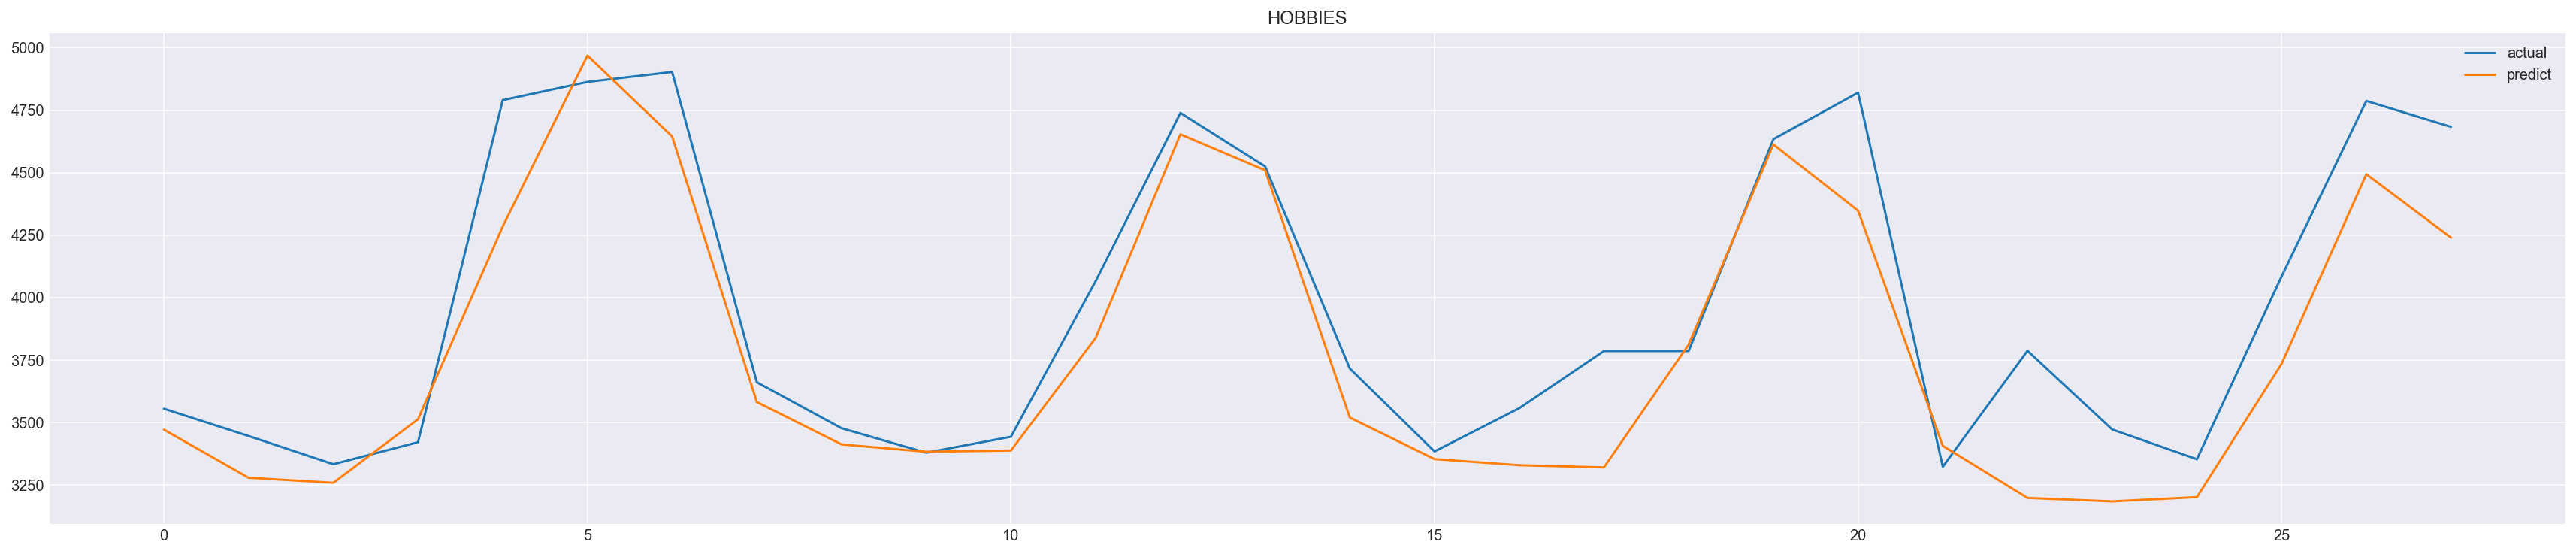

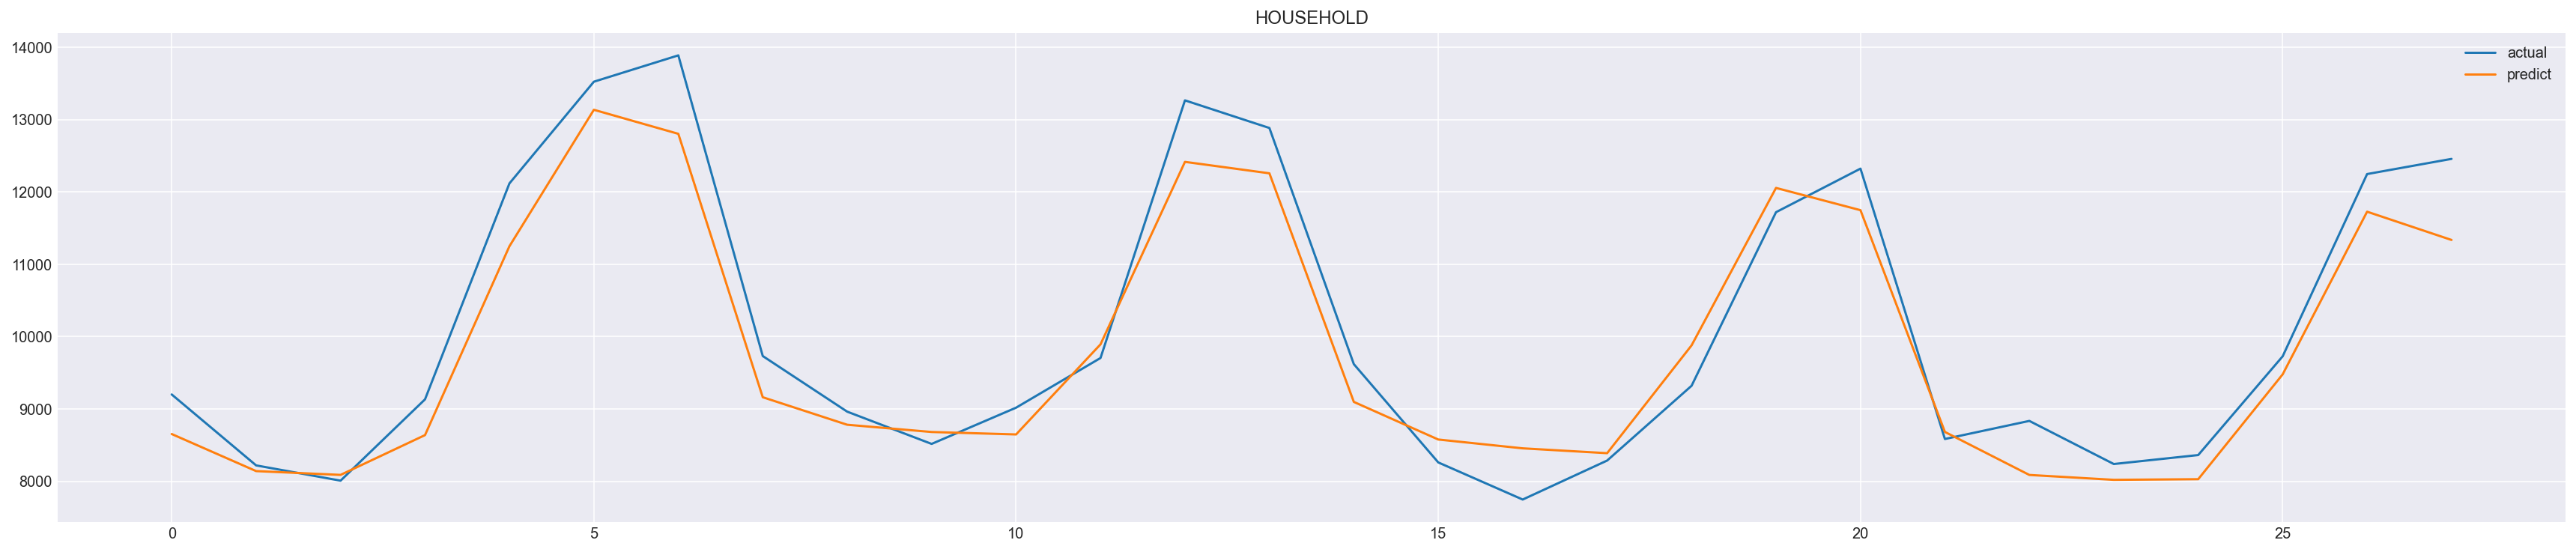

In [142]:
for a in eval_labels['category'].unique():
    actual = eval_labels.groupby('category').sum()
    actual = actual.loc[a].values
    predict = pred_labels.groupby('category').sum()
    predict = predict.loc[a].values
    
    plt.figure(figsize=(30, 6))
    plt.title(a)
    plt.plot(actual, label='actual')
    plt.plot(predict, label='predict')
    plt.legend()
    plt.show()

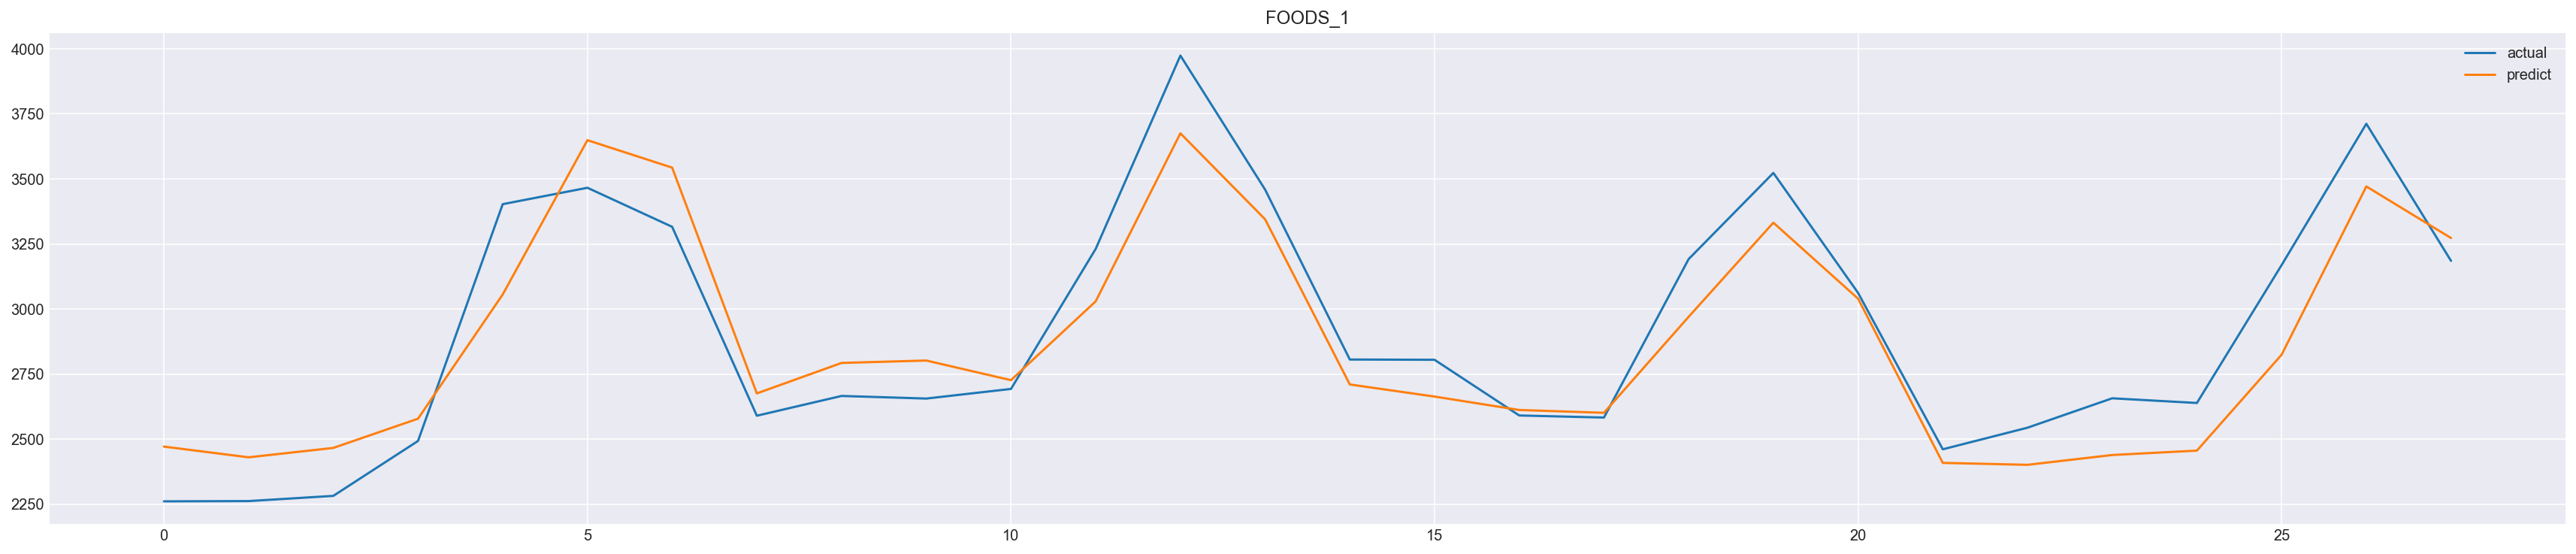

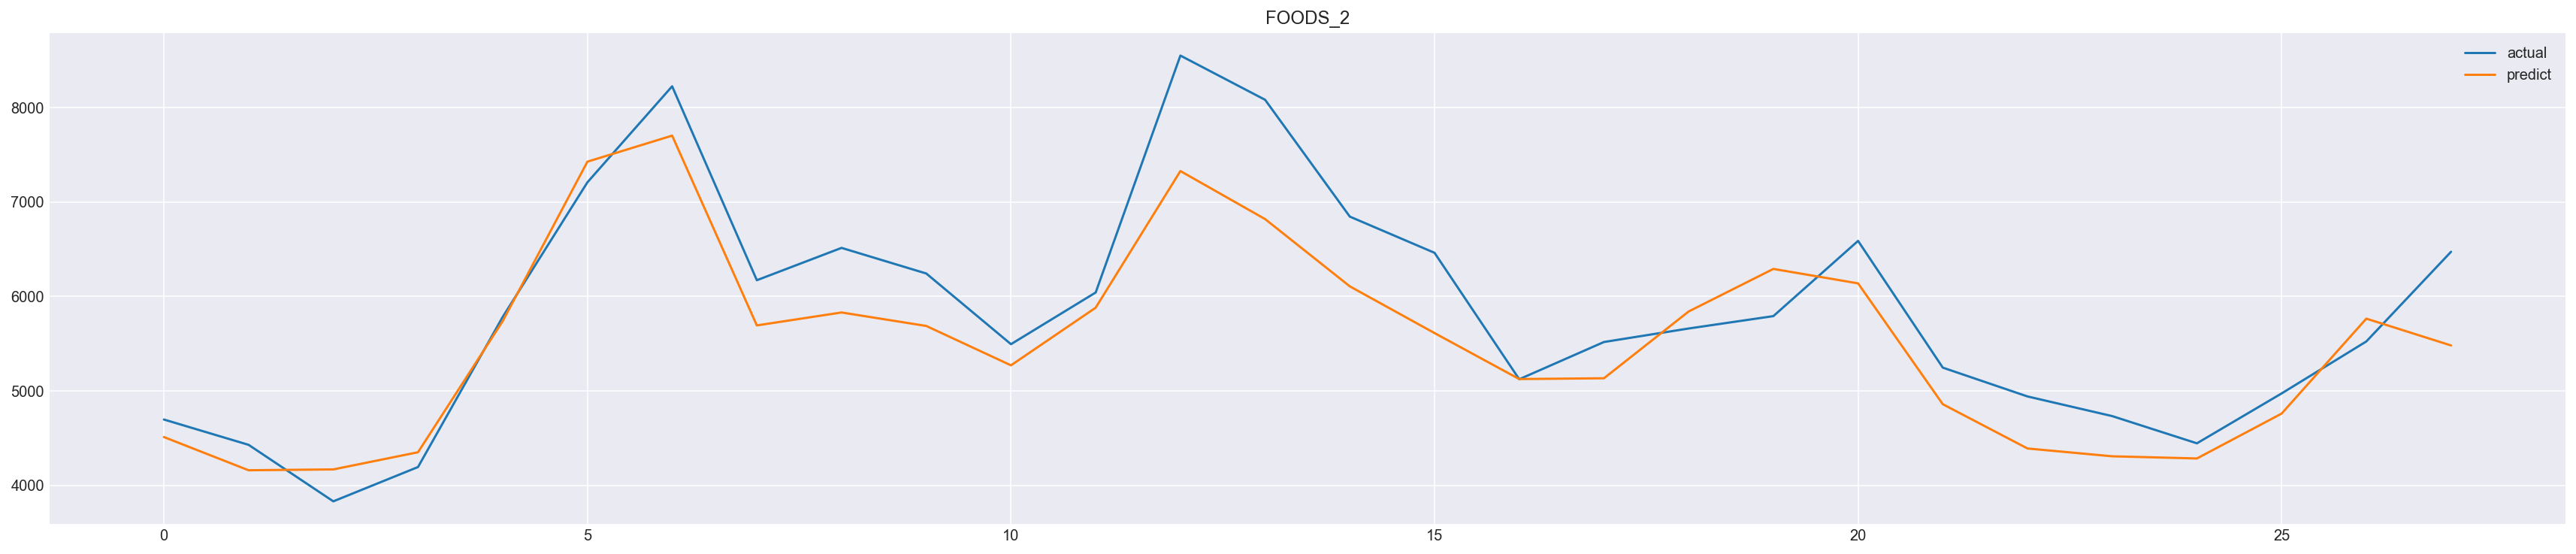

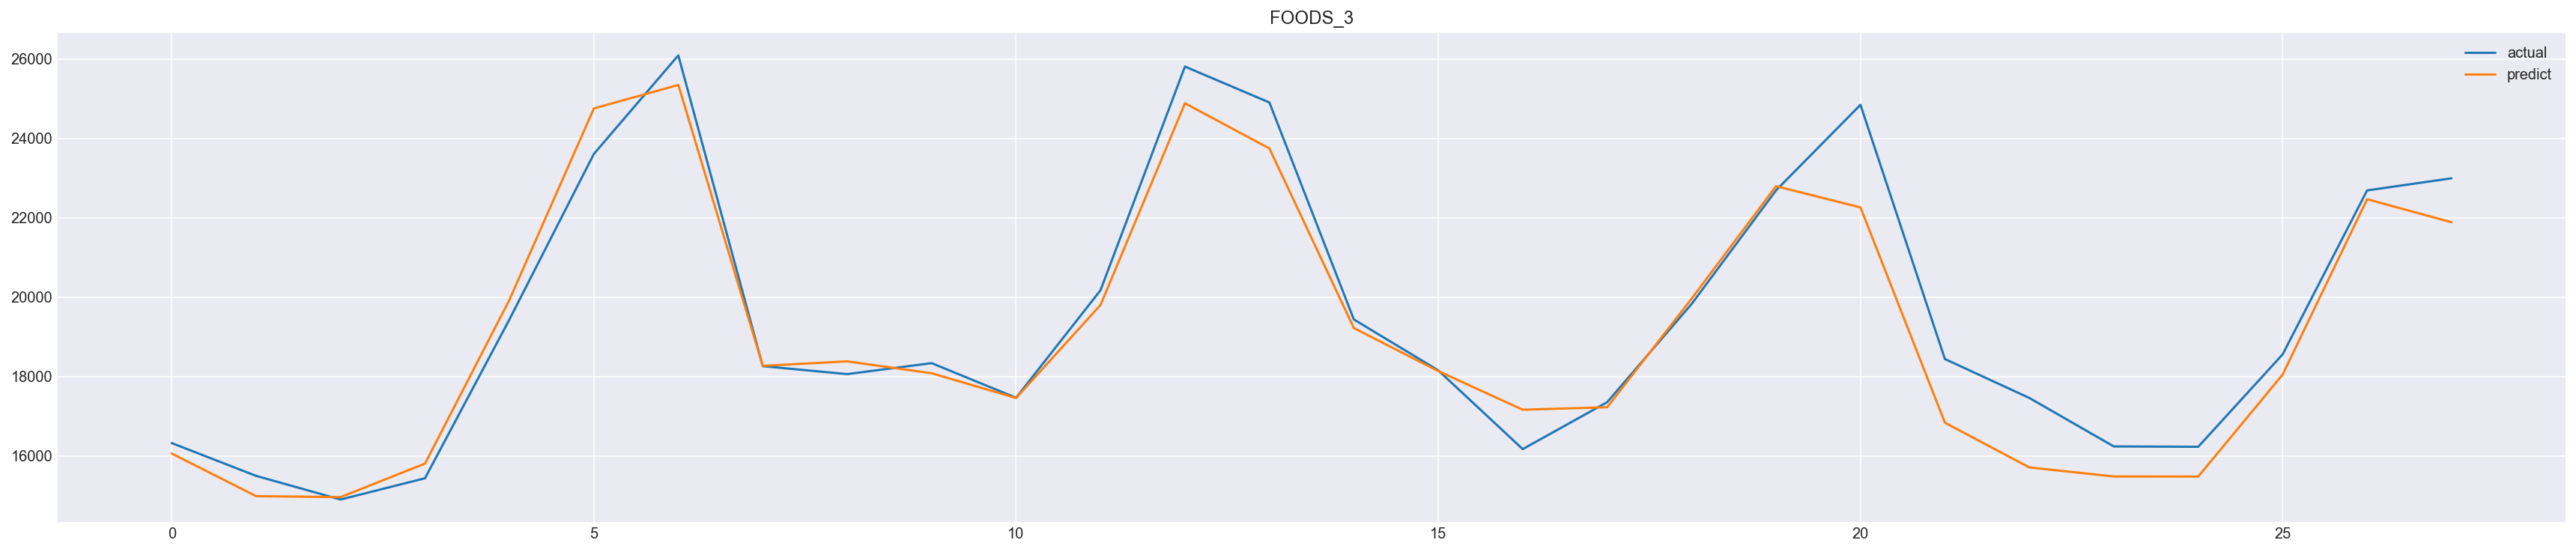

In [152]:
target_item = 'FOODS'
eval_labels_temp = eval_labels.query('category==@target_item')
pred_labels_temp = pred_labels.query('category==@target_item')

for a in eval_labels_temp['item_id'].unique():
    actual = eval_labels_temp.groupby('item_id').sum()
    actual = actual.loc[a].values
    predict = pred_labels_temp.groupby('item_id').sum()
    predict = predict.loc[a].values
    
    plt.figure(figsize=(30, 6))
    plt.title(a)
    plt.plot(actual, label='actual')
    plt.plot(predict, label='predict')
    plt.legend()
    plt.show()

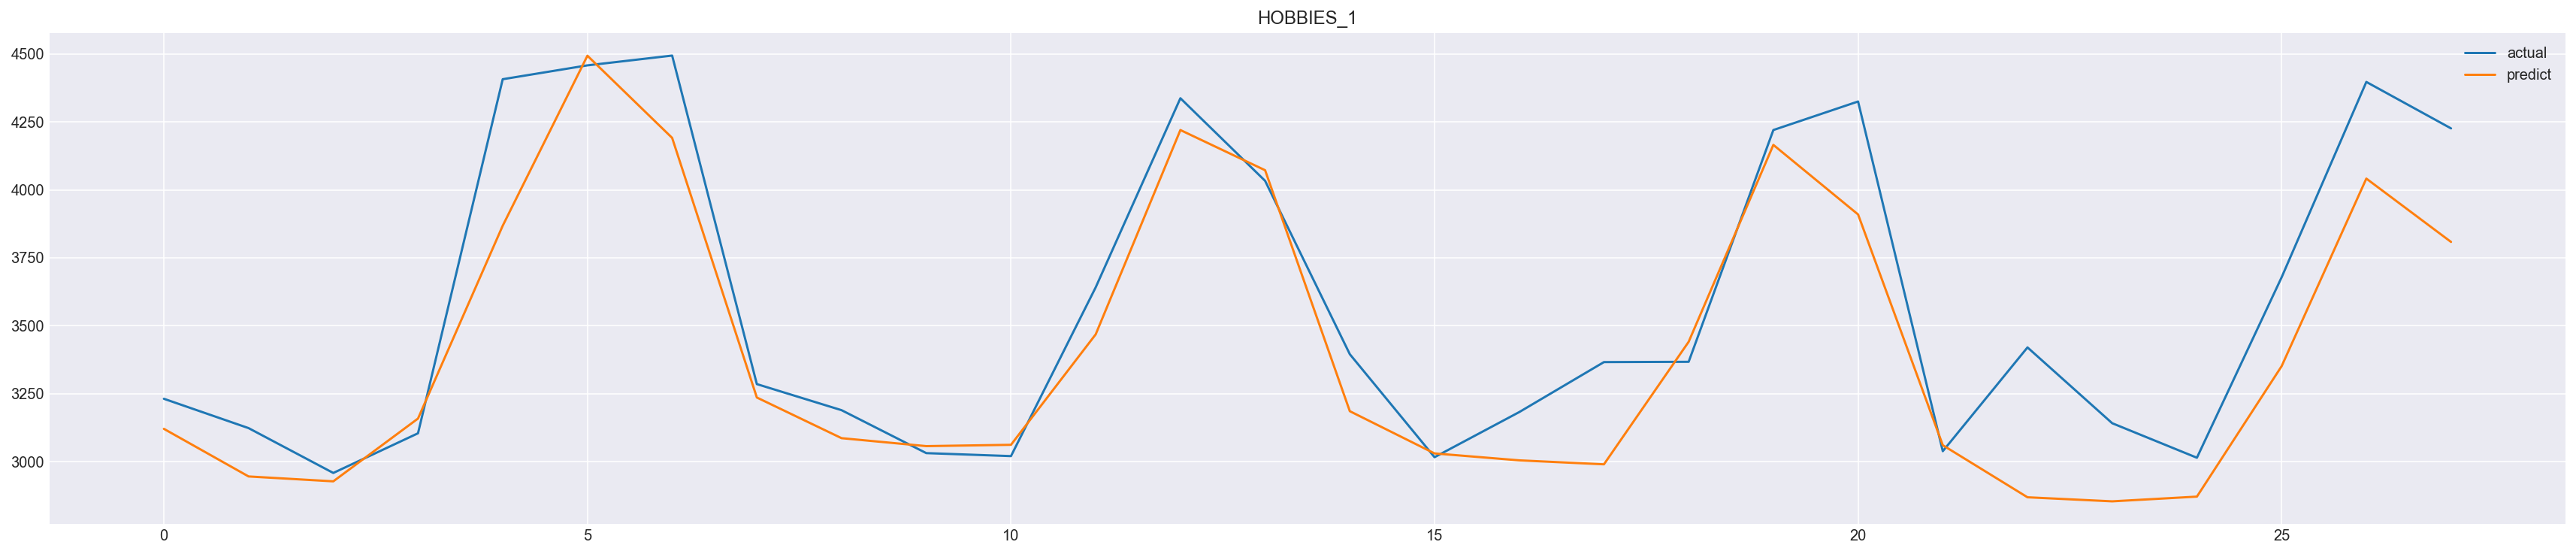

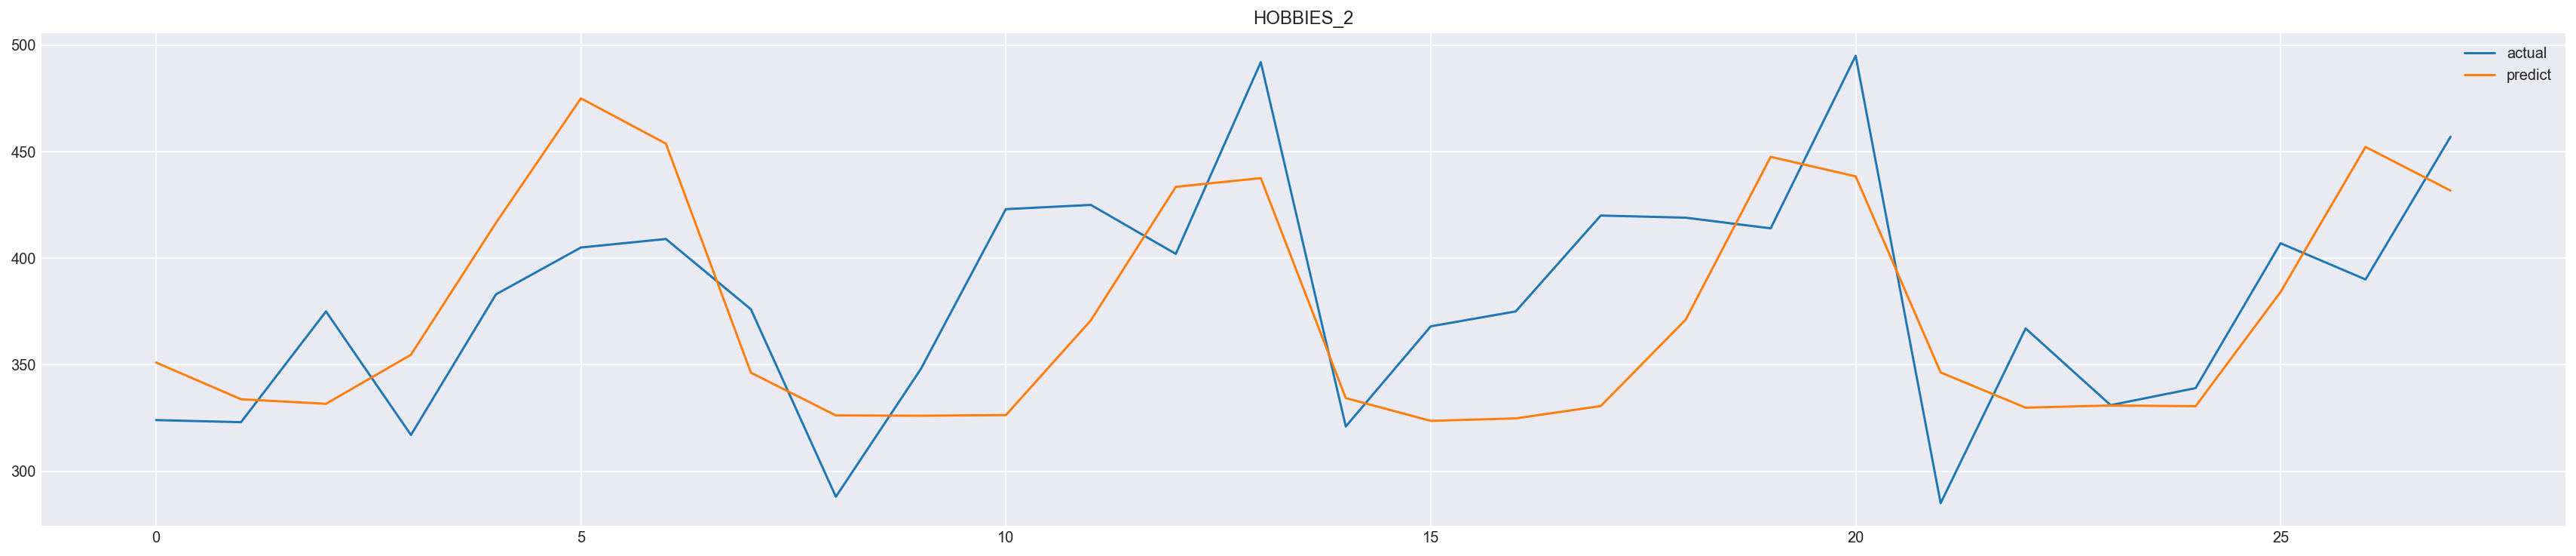

In [153]:
target_item = 'HOBBIES'
eval_labels_temp = eval_labels.query('category==@target_item')
pred_labels_temp = pred_labels.query('category==@target_item')

for a in eval_labels_temp['item_id'].unique():
    actual = eval_labels_temp.groupby('item_id').sum()
    actual = actual.loc[a].values
    predict = pred_labels_temp.groupby('item_id').sum()
    predict = predict.loc[a].values
    
    plt.figure(figsize=(30, 6))
    plt.title(a)
    plt.plot(actual, label='actual')
    plt.plot(predict, label='predict')
    plt.legend()
    plt.show()

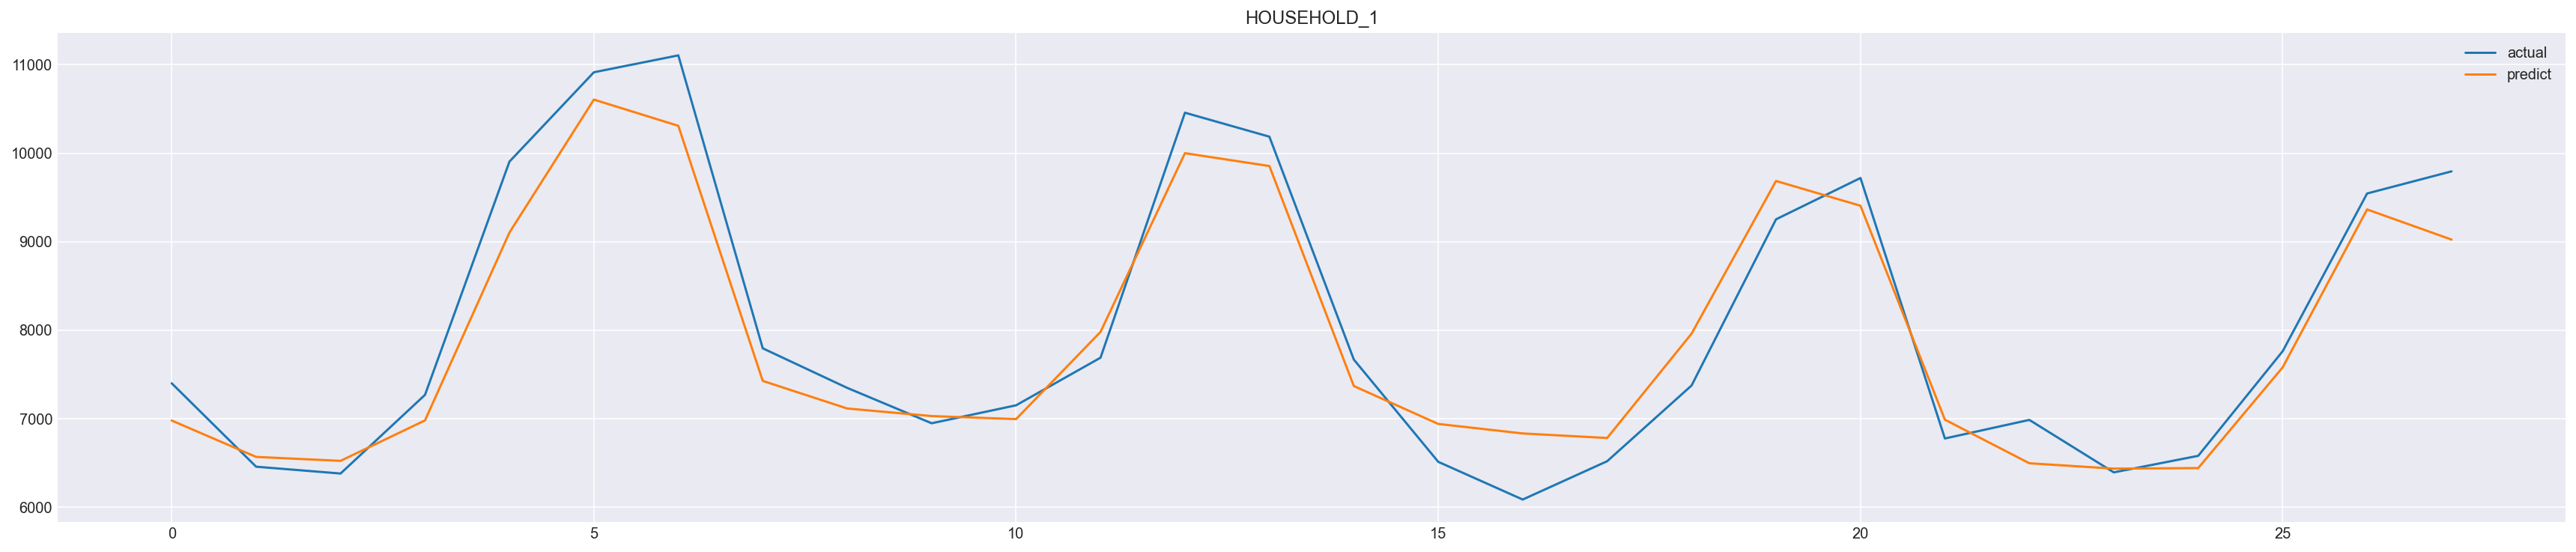

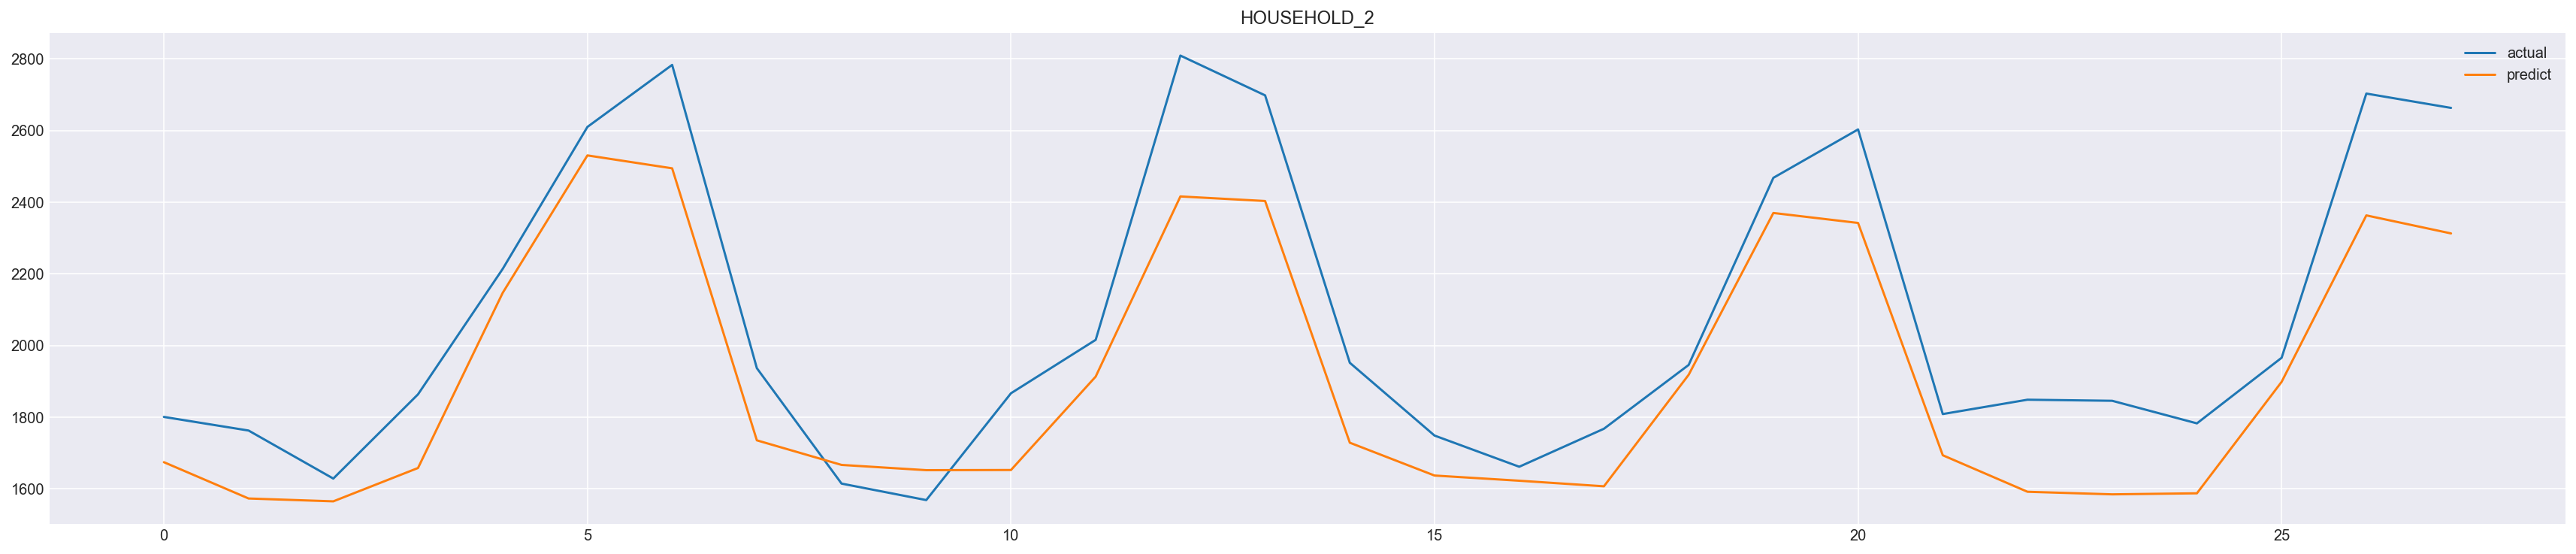

In [157]:
target_item = 'HOUSEHOLD'
eval_labels_temp = eval_labels.query('category==@target_item')
pred_labels_temp = pred_labels.query('category==@target_item')

for a in eval_labels_temp['item_id'].unique():
    actual = eval_labels_temp.groupby('item_id').sum()
    actual = actual.loc[a].values
    predict = pred_labels_temp.groupby('item_id').sum()
    predict = predict.loc[a].values
    
    plt.figure(figsize=(30, 6))
    plt.title(a)
    plt.plot(actual, label='actual')
    plt.plot(predict, label='predict')
    plt.legend()
    plt.show()